# Chapter 2: Small Worlds and Large Worlds
- *Parameter*: Quantities we wish to estimate from the data
- *Likelihood*: The number of ways a value v can produce data
- *Prior*: The initial plausibility assignment for each value of the parameter
- *Posterior*: the relative plausibility of different parameter values conditional the data

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as st

In [25]:
## Doing this first so we can easily plot things from earlier in the chapter
NoneType = type(None)

def grid_approximation(successes, observations, n_points=20, prior=None):
    p_grid = np.linspace(0, 1, n_points)
    #if no prior provided use uniform
    if isinstance(prior, NoneType):
        prior = [1] * n_points
    likelihood = st.binom.pmf(successes, observations, p_grid)
    unstandardized_posterior = likelihood * prior
    posterior = unstandardized_posterior / sum(unstandardized_posterior)
    return pd.Series(posterior, index=p_grid)

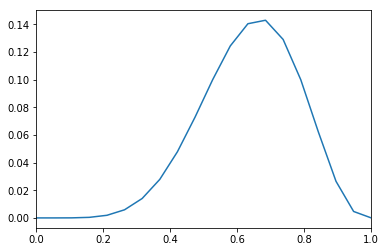

In [13]:
grid_approximation(6, 9).plot()

### 2.2 Bayesian Updating

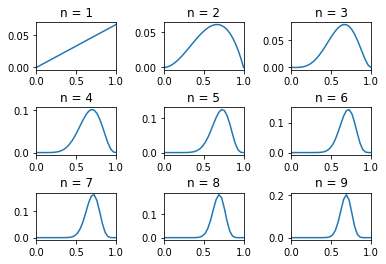

In [39]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.8, wspace=0.6)

toss_sequence = [1, 0, 1, 1, 1, 0, 1, 0, 1]
prior = None
for toss, result in enumerate(toss_sequence):
    posterior = grid_approximation(sum(toss_sequence[:toss+1]), toss+1, 30, prior)
    ax = fig.add_subplot(3, 3, toss+1)
    ax.set_title('n = {}'.format(toss+1))
    posterior.plot(ax=ax)
    prior = posterior

### 2.3 impact of different priors

In [51]:
import itertools

In [57]:
priors = [
    [1] * 30,
    list(itertools.chain([0]*15, [1]*15)),
    list(itertools.chain(np.linspace(0, 1, 15), np.linspace(1, 0, 15)))
]
#priors

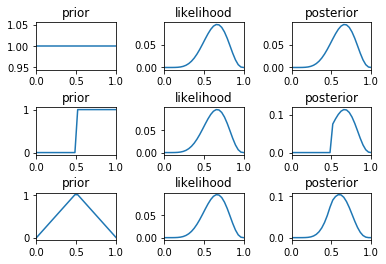

In [77]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.8, wspace=0.6)

i = 1
p_grid = np.linspace(0, 1, 30)
for prior in priors:
    ax = fig.add_subplot(3, 3, i)
    pd.Series(prior, index=p_grid).plot(ax=ax)
    ax.set_title('prior')
    i+= 1

    ax = fig.add_subplot(3, 3, i)
    likelihood = grid_approximation(sum(toss_sequence), len(toss_sequence), 30)
    likelihood.plot(ax=ax)
    ax.set_title('likelihood')
    i+= 1
    
    ax = fig.add_subplot(3, 3, i)
    posterior = grid_approximation(sum(toss_sequence), len(toss_sequence), 30, prior)
    posterior.plot(ax=ax)
    ax.set_title('posterior')
    i+= 1


### 2.4.1 Grid Approximation

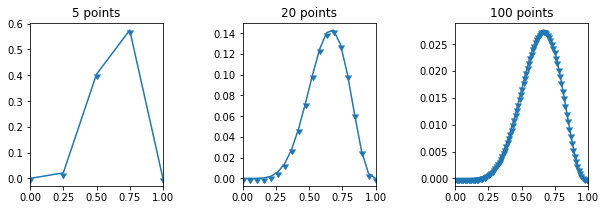

In [87]:
fig = plt.figure(figsize=(10,3))
fig.subplots_adjust(hspace=0.8, wspace=0.6)

for i, points in enumerate([5, 20, 100]):
    ax = fig.add_subplot(1, 3, i+1)
    grid_approximation(sum(toss_sequence), len(toss_sequence), points).plot(ax=ax, marker=11)
    ax.set_title('{} points'.format(points))

### 2.4.2 Quadradic Approximation
1. find the posterior mode (using maximum a posteriori or MAP)
2. estimate the curvature near the peak of the curve to get a quadradic approximation of the entire distribution

In [112]:
# this so slow! apparently pymc is the best way to get the MAP in python (https://conference.scipy.org/scipy2010/slides/lightning/dan_williams_pymc.pdf) but I hate it. 
#TODO calculate MLE then adjust for the prior or some other way of manually calculating this for these simpler examples. But the book doesn't cover it at all?

def quadradic_approximation(w, n):
    with pm.Model() as qa_model:
        p = pm.Uniform('p', 0, 1)
        w = pm.Binomial('w', n=n, p=p, observed=w)
        mean = pm.find_MAP()
        #calculate hessian matrix for std
        hessian = pm.find_hessian(mean, vars=[p])
        std = ((1/hessian)**0.5)[0]
    return mean, std

In [113]:
quadradic_approximation(6, 9)

/Users/rob/.pyenv/versions/3.7.2/envs/wbs/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 1005.93it/s]


({'p_interval__': array(0.69314718), 'p': array(0.66666667)},
 array([0.15713484]))

logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 1967.84it/s]
logp = -2.6477, ||grad|| = 3: 100%|██████████| 7/7 [00:00<00:00, 348.45it/s]
logp = -4.0055, ||grad|| = 6: 100%|██████████| 7/7 [00:00<00:00, 1008.38it/s]


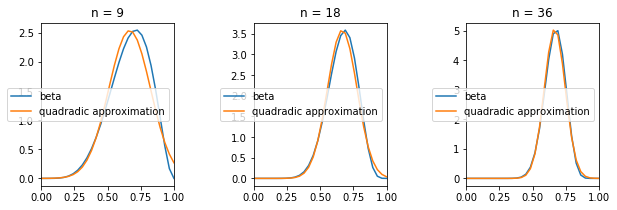

In [119]:
fig = plt.figure(figsize=(10,3))
fig.subplots_adjust(hspace=0.8, wspace=0.6)

i = 1
for w, n in [(6, 9), (12, 18), (24, 36)]:
    ax = fig.add_subplot(1, 3, i)
    mean, std = quadradic_approximation(w, n)
    pd.Series(st.beta.pdf(p_grid, w, n-w), index=p_grid).plot(ax=ax, label='true posterior')
    pd.Series(st.norm.pdf(p_grid, mean['p'], std), index=p_grid).plot(ax=ax, label='quadradic approximation')
    ax.legend(loc=0)
    ax.set_title('n = {}'.format(n))
    i+=1